Counting images in dataset...
Per-class counts:
  Ak: 100
  Ala_Idris: 100
  Buzgulu: 100
  Dimnit: 100
  Nazli: 100
Total images: 500

Creating train / validation datasets using image_dataset_from_directory...

Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.
Training images: 400
Validation images: 100

Class names: ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']


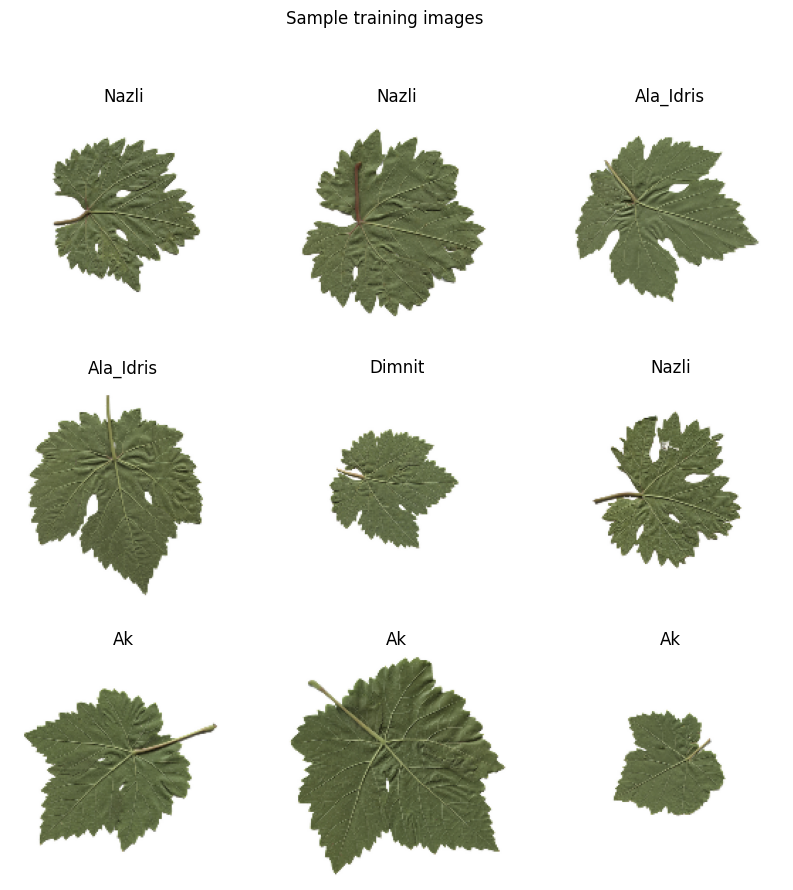

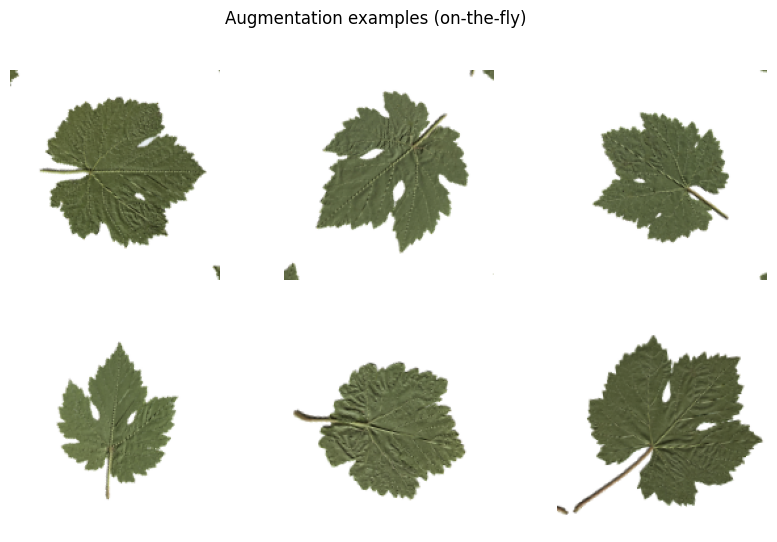

Note: On-the-fly augmentation does not change stored image counts; it is applied during training.

Training images (unchanged): 400
Validation images (unchanged): 100



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 40, 40, 64)        0         
 g2D)                  

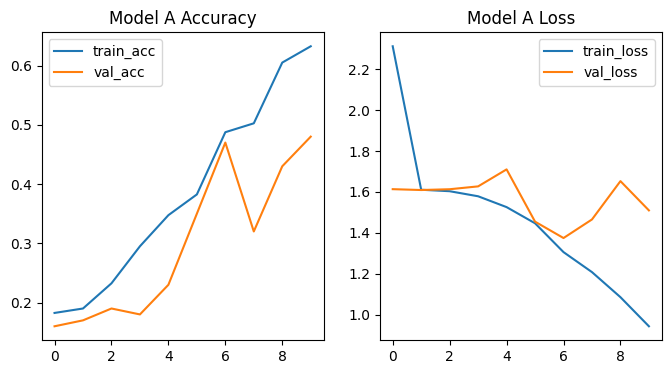

C:\Users\SSN\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Offline augmented dataset not found. Training on-the-fly augmentation model as Model B (augmentation inserted in model).

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 80, 80, 32)        0         
 g2D)                                                            
                                                                 
 co

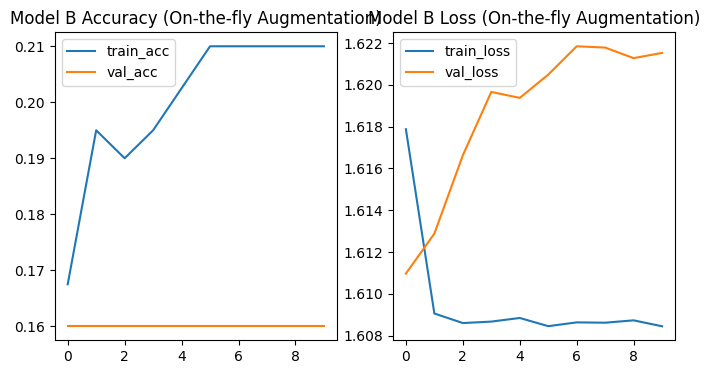

Comparison summary:

Model A history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Model B history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Model A final train acc: 0.6325, val acc: 0.4800
Model B final train acc: 0.2100, val acc: 0.1600


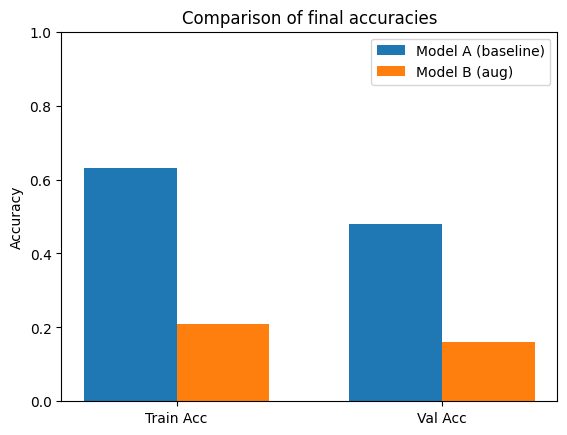

Done.


In [2]:
"""
Grapevine Leaves Classification (5 classes)
Steps implemented:
a. Load the dataset

**(Update: The dataset does NOT contain train/test folders, so we will now auto‑split using train_test_split.)**
```python
import os
import shutil
from sklearn.model_selection import train_test_split

DATA_DIR = r"path_to_extracted_dataset"  # <-- UPDATE THIS

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d)) and d not in ["train", "test"]]

for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    images = os.listdir(cls_path)

    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(TRAIN_DIR, cls), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(TRAIN_DIR, cls, img))

    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(TEST_DIR, cls, img))

print("Train/Test folders created successfully!")
```
b. Show the number of testing and training images
c. Plot some images
d. Do image augmentation – contrast, flipping and rotation
e. After augmentation, show the number of testing and training images
f. Normalizing the training data
g. Build a convolutional neural network to train images (model A - no offline augmentation)
h. Show the training and testing accuracy for model A
i. Build a convolutional neural network to train images (model B - with offline augmentation / expanded dataset)
j. Show the training and testing accuracy for model B
k. Compare the training and testing accuracy before and after augmentation

INSTRUCTIONS BEFORE RUNNING:
1. Download the dataset from Kaggle: https://www.kaggle.com/datasets/muratkokludataset/grapevine-leaves-image-dataset
2. Unzip and place the dataset folder so that each class folder is inside a parent directory, for example:

   dataset/
     ├─ class_1/
     ├─ class_2/
     ├─ class_3/
     ├─ class_4/
     └─ class_5/

3. Set DATA_DIR variable below to the parent folder path (where the class subfolders are).
4. Run this notebook (in Jupyter or any Python environment with TensorFlow installed).

REQUIREMENTS (pip install if needed):
- tensorflow (>=2.6)
- matplotlib
- numpy
- scikit-learn
- tqdm

Example pip install:
    pip install tensorflow matplotlib numpy scikit-learn tqdm

"""

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# ---------------------- USER SETTINGS ----------------------
DATA_DIR = "archive (3)/Grapevine_Leaves_Image_Dataset"  # <-- change this to where you put the extracted dataset
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
SEED = 123
VAL_SPLIT = 0.2
# How many augmented images to generate per original when doing offline augmentation
AUG_PER_IMAGE = 2
# -----------------------------------------------------------

assert os.path.exists(DATA_DIR), f"DATA_DIR does not exist: {DATA_DIR}. Please download and extract the Kaggle dataset and set DATA_DIR correctly."

# Utility: count images per class and total
def count_images_in_dir(parent_dir):
    parent = Path(parent_dir)
    classes = [p.name for p in parent.iterdir() if p.is_dir()]
    counts = {}
    total = 0
    for c in classes:
        n = sum(1 for _ in (parent / c).glob("**/*") if _.is_file())
        counts[c] = n
        total += n
    return counts, total

# a. Load the dataset using image_dataset_from_directory (we'll create train and test splits)
print("Counting images in dataset...")
class_counts, total_images = count_images_in_dir(DATA_DIR)
print("Per-class counts:")
for k,v in class_counts.items():
    print(f"  {k}: {v}")
print(f"Total images: {total_images}\n")

# b. Show number of training and testing images (by splitting)
print("Creating train / validation datasets using image_dataset_from_directory...\n")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

num_train = 0
num_val = 0
for x, y in train_ds:
    num_train += x.shape[0]
for x, y in val_ds:
    num_val += x.shape[0]

print(f"Training images: {num_train}")
print(f"Validation images: {num_val}\n")

# c. Plot some images
class_names = train_ds.class_names
print("Class names:", class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.suptitle("Sample training images")
plt.show()

# d. Do the image augmentation – contrast, flipping and rotation
# We will demonstrate two approaches:
# 1) On-the-fly augmentation used during training (does not change number of stored images)
# 2) Offline augmentation: generate AUG_PER_IMAGE augmented images per original image and save them to a new folder -> this increases dataset size (and we will retrain on this expanded set)

# Augmentation pipeline (Keras preprocessing layers)
augmentation = keras.Sequential([
    layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
])

# Show augmentation examples
sample_batch = next(iter(train_ds.take(1)))[0]
aug_examples = augmentation(sample_batch, training=True)
plt.figure(figsize=(10, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(aug_examples[i].numpy().astype("uint8"))
    plt.axis('off')
plt.suptitle("Augmentation examples (on-the-fly)")
plt.show()

# e. After augmentation, show number of testing and training images
print("Note: On-the-fly augmentation does not change stored image counts; it is applied during training.\n")
print(f"Training images (unchanged): {num_train}")
print(f"Validation images (unchanged): {num_val}\n")

# If you want to expand dataset offline (create new images and save), use the code below. This will create a new folder 'dataset_augmented' where each class has original + generated images.

def create_offline_augmented_dataset(src_dir, dest_dir, aug_per_image=2):
    src = Path(src_dir)
    dst = Path(dest_dir)
    if dst.exists():
        print(f"Destination {dst} exists. To regenerate, delete it first or choose another name.")
        return
    dst.mkdir(parents=True, exist_ok=True)

    # Build a small Keras model to run augmentation and return uint8 images
    inp = layers.Input(shape=(*IMG_SIZE, 3))
    out = augmentation(inp)
    aug_model = keras.Model(inputs=inp, outputs=out)

    for cls in [p for p in src.iterdir() if p.is_dir()]:
        (dst / cls.name).mkdir(parents=True, exist_ok=True)
        # copy originals
        for img_path in cls.glob("*"):
            if img_path.is_file():
                shutil.copy(img_path, dst / cls.name / img_path.name)
        # now create augmentations
        images_paths = [p for p in cls.glob("*") if p.is_file()]
        for img_path in tqdm(images_paths, desc=f"Augmenting {cls.name}"):
            try:
                img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
                x = keras.preprocessing.image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                for i in range(aug_per_image):
                    aug_im = aug_model.predict(x, verbose=0)[0]
                    aug_im_uint8 = np.clip(aug_im, 0, 255).astype('uint8')
                    fname = f"{img_path.stem}_aug{i}{img_path.suffix}"
                    keras.preprocessing.image.save_img(dst / cls.name / fname, aug_im_uint8)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")

# To run offline augmentation: uncomment the following lines
# AUG_DEST = './dataset_augmented'
# create_offline_augmented_dataset(DATA_DIR, AUG_DEST, AUG_PER_IMAGE)
# After creation, you can recount and create new datasets using image_dataset_from_directory pointed at AUG_DEST

# f. Normalizing the training data
# We'll use a Rescaling layer to normalize images to [0,1]

normalization_layer = layers.Rescaling(1./255)

# Prepare datasets with caching and prefetch for performance and add normalization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

# g. Build a convolutional neural network to train images (model A - baseline)
num_classes = len(class_names)

def build_model(input_shape=(*IMG_SIZE, 3), num_classes=5):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # Simple conv stack
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

model_a = build_model(input_shape=(*IMG_SIZE,3), num_classes=num_classes)
model_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_a.summary()

# h. Show the training and testing accuracy (train model A)
EPOCHS = 10
history_a = model_a.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# Plot training history for model A
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history_a.history['accuracy'], label='train_acc')
plt.plot(history_a.history['val_accuracy'], label='val_acc')
plt.title('Model A Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_a.history['loss'], label='train_loss')
plt.plot(history_a.history['val_loss'], label='val_loss')
plt.title('Model A Loss')
plt.legend()
plt.show()

# Save model A
model_a.save('model_A_baseline.h5')

# i. Build a convolutional neural network to train images (model B - trained on offline augmented dataset)
# If you created an offline augmented dataset, load it. Otherwise you can train with on-the-fly augmentation by inserting augmentation layer into model.

AUG_DEST = './dataset_augmented'  # where offline augmented dataset will be saved if created
if os.path.exists(AUG_DEST):
    print("Found offline augmented dataset. Building datasets from it...")
    train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
        AUG_DEST,
        validation_split=VAL_SPLIT,
        subset="training",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
        AUG_DEST,
        validation_split=VAL_SPLIT,
        subset="validation",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    train_ds_aug = train_ds_aug.map(lambda x,y: (normalization_layer(x), y)).cache().prefetch(AUTOTUNE)
    val_ds_aug = val_ds_aug.map(lambda x,y: (normalization_layer(x), y)).cache().prefetch(AUTOTUNE)

    print("Counts for augmented dataset (train/val):")
    n_train_aug = sum(x.shape[0] for x,_ in train_ds_aug)
    n_val_aug = sum(x.shape[0] for x,_ in val_ds_aug)
    print(n_train_aug, n_val_aug)

    # Build and train model B
    model_b = build_model(input_shape=(*IMG_SIZE,3), num_classes=num_classes)
    model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history_b = model_b.fit(train_ds_aug, validation_data=val_ds_aug, epochs=EPOCHS)

    # Plot training history for model B
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(history_b.history['accuracy'], label='train_acc')
    plt.plot(history_b.history['val_accuracy'], label='val_acc')
    plt.title('Model B Accuracy (Augmented)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history_b.history['loss'], label='train_loss')
    plt.plot(history_b.history['val_loss'], label='val_loss')
    plt.title('Model B Loss (Augmented)')
    plt.legend()
    plt.show()

    model_b.save('model_B_augmented.h5')
else:
    print("Offline augmented dataset not found. Training on-the-fly augmentation model as Model B (augmentation inserted in model).\n")
    # To use on-the-fly augmentation during training, include the augmentation layers at the start of the model.
    def build_model_with_augmentation(input_shape=(*IMG_SIZE,3), num_classes=5):
        inputs = layers.Input(shape=input_shape)
        x = inputs
        x = augmentation(x, training=True)  # on-the-fly augmentation
        x = layers.Rescaling(1./255)(x)
        x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Flatten()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        model = keras.Model(inputs, outputs)
        return model

    model_b = build_model_with_augmentation(input_shape=(*IMG_SIZE,3), num_classes=num_classes)
    model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_b.summary()
    history_b = model_b.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

    # Plot training history for model B
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(history_b.history['accuracy'], label='train_acc')
    plt.plot(history_b.history['val_accuracy'], label='val_acc')
    plt.title('Model B Accuracy (On-the-fly Augmentation)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history_b.history['loss'], label='train_loss')
    plt.plot(history_b.history['val_loss'], label='val_loss')
    plt.title('Model B Loss (On-the-fly Augmentation)')
    plt.legend()
    plt.show()

    model_b.save('model_B_on_the_fly.h5')

# k. Compare the training and testing accuracy before and after augmentation
print("Comparison summary:\n")
print("Model A history keys:", history_a.history.keys())
if 'history_b' in globals():
    print("Model B history keys:", history_b.history.keys())
    # Simple tabular comparison of final epoch accuracies
    final_a_train_acc = history_a.history['accuracy'][-1]
    final_a_val_acc = history_a.history['val_accuracy'][-1]
    final_b_train_acc = history_b.history['accuracy'][-1]
    final_b_val_acc = history_b.history['val_accuracy'][-1]

    print(f"Model A final train acc: {final_a_train_acc:.4f}, val acc: {final_a_val_acc:.4f}")
    print(f"Model B final train acc: {final_b_train_acc:.4f}, val acc: {final_b_val_acc:.4f}")

    # Bar chart
    labels = ['Train Acc', 'Val Acc']
    a_vals = [final_a_train_acc, final_a_val_acc]
    b_vals = [final_b_train_acc, final_b_val_acc]

    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots()
    ax.bar(x - width/2, a_vals, width, label='Model A (baseline)')
    ax.bar(x + width/2, b_vals, width, label='Model B (aug)')
    ax.set_ylabel('Accuracy')
    ax.set_title('Comparison of final accuracies')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.ylim(0,1)
    plt.show()
else:
    print("Model B training history not available. Ensure you ran Model B training.")

print("Done.")
